##### Inicio

#### Carga de datos

In [1]:
import os
import numpy as np
import pandas as pd
import datetime
import sklearn
import logging
import warnings

from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

#  cargar algoritmos para aprendizaje supervisado
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, mutual_info_classif
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV

# importar fichero con utilidades propias
from commons import myfunctions as myfunc


CPU_COUNT: 8; NODE: amilcar22; sys.version: 3.10.12 (main, Jul  5 2023, 19:22:19) [GCC 11.2.0]
LOKY_MAX_CPU_COUNT: 6
OMP_NUM_THREADS: 2


#### Parámetros a utilizar en el entrenamiento.

Se indican los 3 algoritmos de *selección de características* (eval_selector_xxx) y los 3 algoritmos para la _clasificación_ (eval_clasifier_xxx)

En *param_distributions* se indicar los parámetros que utilizan los algoritmos en la función RandomSearchCV.

Esta celda tiene la etiqueta **parameters** que servirá para poder lanzar los entrenamientos con la utilidad **papermill** pasándole un fichero con los parámetros. Los nuevos parámetros se situarán tras esta celda para tener prevalencia.

In [2]:
#  Parametros para el entrenamiento

SEMILLA=        42
M_TIPO=         "mul_m"
M_SELECT=       "MI"
M_CLASIF=       "SVM"
R_FICHERO=      "resultados"
M_FICHERO=      "metricas"
PRE_DATA_FILE=  "rows_transpose_norm_by_gene_id_with_target_num_"
SCORING=        "roc_auc_ovr" 
MAX_ITERS=      100

def mutual_info_classif_state(X, y):
    return mutual_info_classif(X, y, random_state=SEMILLA)

eval_selector_mi = "SelectKBest(score_func=mutual_info_classif_state)"
eval_selector_rf=  "SelectFromModel(estimator=RandomForestClassifier(random_state=SEMILLA), threshold=-np.inf)"
eval_selector_anova=  "SelectKBest(score_func=f_classif)"

eval_clasifier_svm= "SVC(probability=True, random_state=SEMILLA)"
eval_clasifier_rf= "RandomForestClassifier(random_state=SEMILLA)"
eval_clasifier_lr= "LogisticRegressionCV(random_state=SEMILLA)"

if M_TIPO.startswith("bin_m"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
    eval_selector = eval_selector_mi
    eval_clasifier = eval_clasifier_svm

    SEMILLA = 6578
    M_SELECT = "MI"
    M_CLASIF = "SVM"
    param_distributions = {'selector__k': [1000], 
         'clasifier__kernel': ['rbf'], 'clasifier__gamma': [0.01], 'clasifier__C': [100]}
elif M_TIPO.startswith("bin_s"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
    eval_selector = eval_selector_rf
    eval_clasifier = eval_clasifier_lr

    SEMILLA = 6191
    M_SELECT = "RF"
    M_CLASIF = "LR_L2"
    param_distributions = {'selector__max_features': [1000], 'selector__estimator__n_estimators': [200], 
        'clasifier__solver': ['lbfgs'], 'clasifier__penalty': ['l2'], 'clasifier__max_iter': [10000]}

elif M_TIPO.startswith("mul_m"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
 
    eval_selector = eval_selector_rf
    eval_clasifier = eval_clasifier_lr

    SEMILLA = 6191
    M_SELECT = "RF"
    M_CLASIF = "LR_L2"
    param_distributions = {'selector__max_features': [1000], 'selector__estimator__n_estimators': [400], 
        'clasifier__solver': ['lbfgs'], 'clasifier__penalty': ['l2'], 'clasifier__max_iter': [10000]}

else:
    # M_TIPO.startswith("mul_s"):
    myfunc.verbose(f"Utilizando parámetros de {M_TIPO}")
    eval_selector = eval_selector_anova
    eval_clasifier = eval_clasifier_lr

    SEMILLA = 1860
    M_SELECT = "ANOVA"
    M_CLASIF = "LR_L2"
    param_distributions = {'selector__k': [1000], 
        'clasifier__solver': ['saga'], 'clasifier__penalty': ['l2'], 'clasifier__max_iter': [10000]}



20231030T042059 : amilcar22 : INFO : Utilizando parámetros de mul_m


In [3]:
# Parameters
M_TIPO = "mul_s"
M_SELECT = "ANOVA"
M_CLASIF = "SVM"
P_FICHERO = "param_0000_1466_mul_s_ANOVA_SVM.yaml"
R_FICHERO = "resultados_1466"
M_FICHERO = "metricas_1466"
PRE_DATA_FILE = "rows_transpose_norm_by_gene_id_with_target_num_"
SCORING = "roc_auc_ovr"
SEMILLA = 1466
MAX_ITERS = 500
eval_selector = "SelectKBest(score_func=f_classif)"
eval_clasifier = "SVC(probability=True, random_state=SEMILLA)"
param_distributions = {
    "selector__k": [200],
    "clasifier__kernel": ["rbf"],
    "clasifier__gamma": [0.01],
    "clasifier__C": [10],
}


In [4]:
DATA_FILE = PRE_DATA_FILE + M_TIPO

# si viene "None" en el parámetro max_depth, se le quitan las comillas para que no sea entendido por el algoritmo como un texto
if "clasifier__max_depth" in param_distributions:
    param_distributions['clasifier__max_depth'] = [None if x == 'None' else x for x in param_distributions['clasifier__max_depth']]

Asignar los algoritmos que se utilizarán en la función RandomSearchCV

In [5]:
algor_selector=eval(eval_selector)
algor_clasifier=eval(eval_clasifier)

#### Comprobar el entorno y leer fichero de muestras

In [6]:
start_time = datetime.datetime.now()

myfunc.reset_vars()

myfunc.NOTEBK_FILENAME = myfunc.get_nb_name()

myfunc.check_enviroment(myfunc.DATA_DIR, myfunc.CFDNA_DIR, myfunc.GENCODE_DIR, myfunc.H5_DIR, myfunc.LOG_DIR, myfunc.CSV_DIR, myfunc.MODEL_DIR, myfunc.EXEC_DIR, myfunc.MET_DIR)

# Leer fichero con las muestras
df_t = myfunc.read_h5_to_df(DATA_FILE, myfunc.H5_DIR)
display(df_t.groupby("target").size())
print("Shape df:",df_t.shape)

# Separar caracteristicas/genes de las etiquetas/tipos de cáncer
X = df_t.iloc[:, :-1]  # Todas las columnas excepto la última
y = df_t.iloc[:, -1]  # La última columna contiene los identificadores de los tipos de cáncer

#  Crear el conjunto de datos de entrenamiento y de pruebas, y se fija la semilla para siempre coger el mismo juego de muestras
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
print("Shape X_train:",X_train.shape)
print("Shape X_test:",X_test.shape)


20231030T042059 : amilcar22 : INFO : Encontrada carpeta DATA_DIR=../tfm_git/datos
20231030T042059 : amilcar22 : INFO : Encontrada carpeta CFDNA_DIR=../tfm_git/datos/cfDNA_5hmC
20231030T042059 : amilcar22 : INFO : Encontrada carpeta GENCODE_DIR=../tfm_git/datos/gencode
20231030T042059 : amilcar22 : INFO : Encontrada carpeta H5_DIR=../tfm_git/datos/h5
20231030T042059 : amilcar22 : INFO : Encontrada carpeta LOG_DIR=../tfm_git/datos/logs
20231030T042059 : amilcar22 : INFO : Encontrada carpeta CSV_DIR=../tfm_git/datos/csv
20231030T042059 : amilcar22 : INFO : Encontrada carpeta MODEL_DIR=../tfm_git/ejecuciones/modelos
20231030T042059 : amilcar22 : INFO : Encontrada carpeta EXEC_DIR=../tfm_git/ejecuciones
20231030T042059 : amilcar22 : INFO : Encontrada carpeta MET_DIR=../tfm_git/ejecuciones/metricas
20231030T042059 : amilcar22 : INFO : Inicio leer fichero h5 ../tfm_git/datos/h5/rows_transpose_norm_by_gene_id_with_target_num_mul_s.h5
20231030T042059 : amilcar22 : INFO : Leyendo clave /df
20231

target
0    37
1    37
2    37
3    37
4    37
5    37
6    37
dtype: int64

Shape df: (259, 18876)
Shape X_train: (207, 18875)
Shape X_test: (52, 18875)


#### Selección de características y clasificación.

In [7]:
myfunc.verbose("Iniciando entrenamiento")

kf = KFold(n_splits=5, shuffle=True, random_state=SEMILLA)

# Crear el pipeline para el flujo de tareas
tasks_pipeline = Pipeline([
    ('selector', algor_selector),
    ('clasifier', algor_clasifier)
])

# MAX_ITERS puede limitar el número de iteraciones si son excesivas para las combinaciones de parámetros buscando un óptimo local, 
# sino funcionaría como GridSearchCV al revisar todas las cominaciones de los parámetros
num_iteraciones = 1
num_iteraciones = num_iteraciones * np.prod([len(elemento1) for _, elemento1 in param_distributions.items()])
max_iteraciones = num_iteraciones if num_iteraciones <= MAX_ITERS else MAX_ITERS
print("num_iter:",num_iteraciones,", max_iter:",max_iteraciones)

random_search = RandomizedSearchCV(
    tasks_pipeline, 
    param_distributions, 
    n_iter=max_iteraciones,
    scoring=SCORING,
    cv=kf,
    verbose=3, 
    random_state=SEMILLA, 
    n_jobs=-1
    )

# Entrenar el modelo
random_search.fit(X_train, y_train)

# Ver los mejores hiperparámetros encontrados
print(f'Mejores Hiperparámetros: {random_search.best_params_}')
print(f'Mejor Puntuación: {random_search.best_score_:.4f}')

# Nos quedamos con el mejor modelo para ver las métricas
mejor_modelo = random_search.best_estimator_

myfunc.verbose("Fin entrenamiento")

20231030T042059 : amilcar22 : INFO : Iniciando entrenamiento
num_iter: 1 , max_iter: 1
Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/antonio/miniconda3/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  298  1508  1733  1846  2010  2222  2265  2266  2273  2553  2688  2802
  2803  2833  2896  3248  3415  3492  4075  5490  5803  6053  6981  6984
  7418  8508  8510  8513  8890  9087  9490 10475 11020 11021 11022 11565
 11613 11943 12249 12480 12518 12831 13235 13259 13836 13959 14000 14015
 14244 14245 14451 14789 14795 14941 15397 15401 15515 15563 15785 15824
 15874 16258 16267 16268 16281 16287 16294 16313 16322 16323 16339 16347
 16350 16372 16565 16630 16701 16870 16905 16906 16956 16968 17047 17055
 17075 17091 17093 17231 17264 17274 17300 17312 17540 17741 18153 18241
 18245 18350 18368 18374 18375 18381 18405 18486 18592 18608 18692 18698
 18868] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/antonio/miniconda3/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:11

/home/antonio/miniconda3/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  298  1085  1508  1733  1846  2006  2010  2222  2265  2266  2553  2555
  2688  2802  2803  2833  2896  2957  3248  3415  3492  4075  5668  5803
  6053  6981  6984  7418  8314  8508  8510  8511  8512  8513  8890  9087
  9090  9490 10475 10477 11020 11562 11613 11943 12249 12421 12480 12489
 12831 12973 13225 13235 13259 13300 13577 13836 13959 14000 14015 14244
 14245 14451 14789 14794 14795 14941 15071 15515 15563 15824 15874 16018
 16235 16258 16267 16268 16276 16277 16281 16287 16313 16318 16323 16350
 16372 16519 16630 16701 16704 16905 16906 16968 17047 17091 17093 17231
 17264 17269 17273 17274 17300 17312 17520 17540 17963 18350 18368 18374
 18375 18405 18486 18530 18592 18692 18868] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/antonio/miniconda3/lib/python3.10/site-packages/sklearn/feature_s

Mejores Hiperparámetros: {'selector__k': 200, 'clasifier__kernel': 'rbf', 'clasifier__gamma': 0.01, 'clasifier__C': 10}
Mejor Puntuación: 0.7555
20231030T042101 : amilcar22 : INFO : Fin entrenamiento


/home/antonio/miniconda3/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [  298  1508  1733  1846  2010  2222  2265  2266  2553  2688  2802  2803
  2833  2896  3248  3415  3492  4075  5803  6053  6981  6984  7418  8508
  8510  8513  8890  9087  9490 10475 11020 11613 11943 12249 12480 12831
 13235 13259 13836 13959 14000 14015 14244 14245 14451 14789 14795 14941
 15515 15563 15824 15874 16258 16267 16268 16281 16287 16313 16323 16350
 16372 16630 16701 16905 16906 16968 17047 17091 17093 17231 17264 17274
 17300 17312 17540 18350 18368 18374 18375 18405 18486 18592 18692 18868] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/home/antonio/miniconda3/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


#### Guardar modelo

In [8]:
fichero_modelo = str.replace("modelo_"+str(SEMILLA).zfill(4)+"_"+M_TIPO+"_"+M_SELECT+"_"+M_CLASIF+".pkl", " ", "_")

myfunc.save_modelo(mejor_modelo, myfunc.MODEL_DIR, fichero_modelo)

20231030T042101 : amilcar22 : INFO : Inicio guardar fichero ../tfm_git/ejecuciones/modelos/modelo_1466_mul_s_ANOVA_SVM.pkl
20231030T042101 : amilcar22 : INFO : Fin guardar fichero ../tfm_git/ejecuciones/modelos/modelo_1466_mul_s_ANOVA_SVM.pkl


#### Ver resultados del las iteraciones hechas por RandomSearchCV

In [9]:
myfunc.ver_resultados_search(random_search)

20231030T042101 : amilcar22 : INFO : Inicio ver resultados
Mejores Hiperparámetros: {'selector__k': 200, 'clasifier__kernel': 'rbf', 'clasifier__gamma': 0.01, 'clasifier__C': 10}
Mejores puntuaciones: 0.7555 | Params: {'selector__k': 200, 'clasifier__kernel': 'rbf', 'clasifier__gamma': 0.01, 'clasifier__C': 10}
Media de las puntuaciones: 0.7555 | Params: {'selector__k': 200, 'clasifier__kernel': 'rbf', 'clasifier__gamma': 0.01, 'clasifier__C': 10}
20231030T042101 : amilcar22 : INFO : Fin resultados


#### Ver métricas del mejor modelo

20231030T042101 : amilcar22 : INFO : Inicio ver métricas multiclase


              precision    recall  f1-score   support

           0       0.50      0.09      0.15        11
           1       0.71      0.62      0.67         8
           2       0.00      0.00      0.00         8
           3       0.10      0.20      0.13         5
           4       0.78      0.88      0.82         8
           5       0.20      0.17      0.18         6
           6       0.25      0.67      0.36         6

    accuracy                           0.37        52
   macro avg       0.36      0.37      0.33        52
weighted avg       0.40      0.37      0.34        52



           Exactitud: 0.365385
   Precisión (media): 0.363152
      Recall (media): 0.374892
    F1-score (media): 0.331833


AUC para el tipo de cáncer 0-Control.... 0.4302
AUC para el tipo de cáncer 1-Bladder.... 0.8182
AUC para el tipo de cáncer 2-Breast..... 0.6648
AUC para el tipo de cáncer 3-Colorectal. 0.8000
AUC para el tipo de cáncer 4-Kidney..... 0.9744
AUC para el tipo de cáncer 5-Lung..

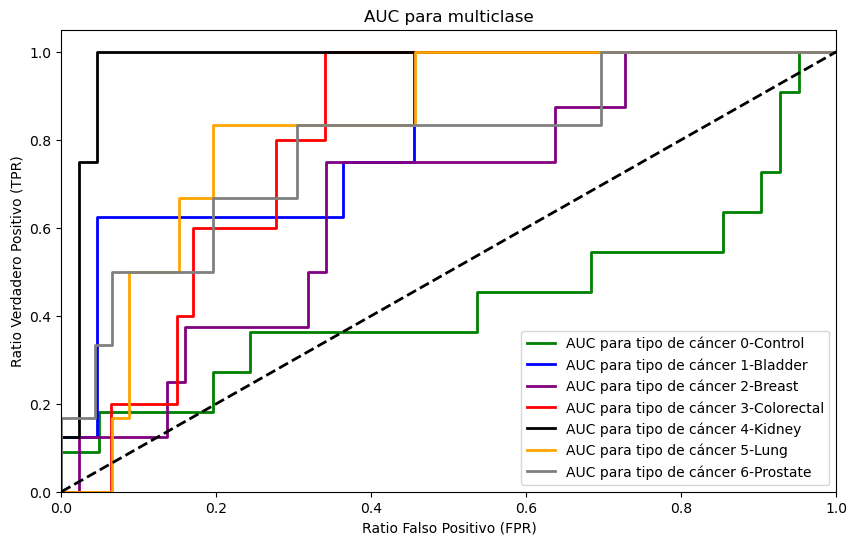

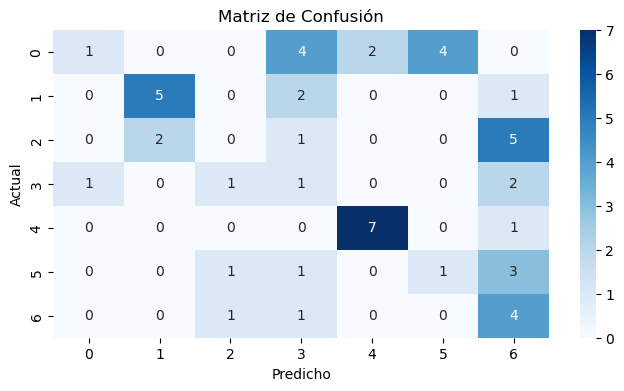



Puntuación Jaccard para el cáncer tipo 0-Control.... 0.0833
Puntuación Jaccard para el cáncer tipo 1-Bladder.... 0.5000
Puntuación Jaccard para el cáncer tipo 2-Breast..... 0.0000
Puntuación Jaccard para el cáncer tipo 3-Colorectal. 0.0714
Puntuación Jaccard para el cáncer tipo 4-Kidney..... 0.7000
Puntuación Jaccard para el cáncer tipo 5-Lung....... 0.1000
Puntuación Jaccard para el cáncer tipo 6-Prostate... 0.2222

Media de la puntuación de Jaccard: 0.2396


In [10]:
if M_TIPO.startswith("bin"):
    myfunc.ver_metricas(mejor_modelo, X_test, y_test)
else:
    myfunc.ver_metricas_multi(mejor_modelo, X_test, y_test)


#### Finalización del notebook

In [11]:
end_time = datetime.datetime.now()
total_time = end_time - start_time
myfunc.verbose(f"Notebook ha tardado {total_time.seconds} seconds")

20231030T042101 : amilcar22 : INFO : Notebook ha tardado 2 seconds


#### Guardar métricas

In [12]:
if M_TIPO.startswith("bin"):
    myfunc.save_metricas_to_csv(random_search, X_test, y_test, M_TIPO, M_SELECT, M_CLASIF, total_time, SEMILLA, myfunc.MET_DIR, M_FICHERO, fichero_modelo)
else:
    myfunc.save_metricas_multi_to_csv(random_search, X_test, y_test, M_TIPO, M_SELECT, M_CLASIF, total_time, SEMILLA, myfunc.MET_DIR, M_FICHERO, fichero_modelo)

df1=myfunc.read_metricas_to_df(myfunc.MET_DIR,M_FICHERO)

display(df1.sort_values("datetime", ascending=False)[:3])


20231030T042101 : amilcar22 : INFO : Inicio guardar métricas multiclase
20231030T042101 : amilcar22 : INFO : Inicio leer fichero ../tfm_git/ejecuciones/metricas/metricas_1466.csv
20231030T042101 : amilcar22 : INFO : Fin leer fichero ../tfm_git/ejecuciones/metricas/metricas_1466.csv


20231030T042101 : amilcar22 : INFO : Inicio guardar fichero ../tfm_git/ejecuciones/metricas/metricas_1466.csv
20231030T042101 : amilcar22 : INFO : Fichero borrado ../tfm_git/ejecuciones/metricas/metricas_1466.csv
20231030T042101 : amilcar22 : INFO : Fin guardar fichero ../tfm_git/ejecuciones/metricas/metricas_1466.csv
20231030T042101 : amilcar22 : INFO : Fin guardar métricas multiclase
20231030T042101 : amilcar22 : INFO : Inicio leer fichero ../tfm_git/ejecuciones/metricas/metricas_1466.csv


20231030T042101 : amilcar22 : INFO : Fin leer fichero ../tfm_git/ejecuciones/metricas/metricas_1466.csv


,tipo,select,clasific,semilla,accuracy,precision,recall,f1_score,roc_auc,hostname,total_time_sec,datetime,fichero_modelo,params,shape,features,roc_auc_ovr,indices_auc,indices_jaccard
0,mul_s,ANOVA,SVM,1466,0.365385,0.363152,0.374892,0.331833,NaN,amilcar22,2,2023-10-30 04:21:01.967320,modelo_1466_mul_s_ANOVA_SVM.pkl,"{'selector__k': 200, 'clasifier__kernel': 'rbf...","X_test:(52, 18875)","['ENSG00000000938.13', 'ENSG00000005381.9', 'E...",0.756605,"[0.43015521064301554, 0.8181818181818181, 0.66...","[0.08333333333333333, 0.5, 0.0, 0.071428571428..."
0,mul_s,ANOVA,RF,1466,0.269231,0.238095,0.261797,0.245338,NaN,amilcar22,7,2023-10-30 04:20:53.049731,modelo_1466_mul_s_ANOVA_RF.pkl,"{'selector__k': 500, 'clasifier__n_estimators'...","X_test:(52, 18875)","['ENSG00000000938.13', 'ENSG00000002919.15', '...",0.707277,"[0.4079822616407982, 0.8125, 0.678977272727272...","[0.0625, 0.3333333333333333, 0.0, 0.0769230769..."
0,mul_s,ANOVA,LR_L2,1466,0.576923,0.595563,0.591126,0.559642,NaN,amilcar22,622,2023-10-30 04:20:39.481744,modelo_1466_mul_s_ANOVA_LR_L2.pkl,"{'selector__k': 1000, 'clasifier__solver': 'sa...","X_test:(52, 18875)","['ENSG00000000938.13', 'ENSG00000002834.19', '...",0.840903,"[0.6452328159645233, 0.9034090909090908, 0.735...","[0.3125, 0.375, 0.2727272727272727, 0.3, 0.727..."


#### Guardar resultados

In [13]:
fichero_resultados=R_FICHERO+"_"+M_TIPO+"-"+M_SELECT+"-"+M_CLASIF+".csv"
myfunc.save_resultados_to_csv(M_TIPO, M_SELECT, M_CLASIF,  random_search, myfunc.MET_DIR, fichero_resultados)


20231030T042102 : amilcar22 : INFO : Inicio guardar resultados
20231030T042102 : amilcar22 : INFO : Inicio guardar fichero ../tfm_git/ejecuciones/metricas/resultados_1466_mul_s-ANOVA-SVM.csv
20231030T042102 : amilcar22 : INFO : Fin guardar fichero ../tfm_git/ejecuciones/metricas/resultados_1466_mul_s-ANOVA-SVM.csv
20231030T042102 : amilcar22 : INFO : Fin guardar resultados
